# Failure Analysis - ResNet

### Imports

In [1]:
# Packages
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import models
import pandas as pd
import numpy as np
import argparse
import sys
import os
import argparse
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import random

In [2]:
# Local Imports
sys.path.append(".")
sys.path.append("..")
from dataset.slice_dataset import SliceDataset
from models.omnipotent_resnet import Net
from visualisation.analysis_plotter import plot_confusion_matrix, plot_roc_curve
from visualisation.slice_plotter import plot_slice_by_acquisition

### Parameters

In [3]:
### Data parameters ###
DATA_DIR = 'D:/data/train'  # The slices we will train on for each patient
DS_DIR = 'D:/data/data-split' # Directory containing data split files
TARGET_SLICES = (0, 32)
### Model parameters ###
MODEL_DIR = '../../models'  # Directory where best models are saved
TRAINED_MODEL = 'resnet34_009.pt'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on GPU or CPU
RESNET_MODEL_TYPE = 'resnet34'  # Which type of resnet is used by the model
N_FEATURES = 128  # The length of feature vectors that the ResNet will output in the combined network

### Loading Model

In [4]:
# Load in correct model
if RESNET_MODEL_TYPE == "resnet50":
    model = models.resnet50()
elif RESNET_MODEL_TYPE == "resnet34":
    model = models.resnet34()
elif RESNET_MODEL_TYPE == "resnet18":
    model = models.resnet18()
else:
    print(f'No resnet with name {RESNET_MODEL_TYPE}')
    exit()
# Change the pre-defined resnet to our own defined model
resnet = Net(model, 'resnet', N_FEATURES)
# Load network weights
resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, TRAINED_MODEL)))
resnet.to(DEVICE)

Net(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### Loading Data

In [5]:
val_df = pd.read_csv(os.path.join(DS_DIR, "val_df.csv"), names=["patient_nr", "slice_nr", "class"])
print(f"\nNumber of unique patient numbers in validation set: {len(np.unique(val_df['patient_nr']))}")
print(f"Number of unique slice numbers in validation set:   {len(np.unique(val_df['slice_nr']))}")
print(f"Number of unique class values in validation set:    {len(np.unique(val_df['class']))}")


Number of unique patient numbers in validation set: 100
Number of unique slice numbers in validation set:   32
Number of unique class values in validation set:    2


In [6]:
val_df.head()

,patient_nr,slice_nr,class
160,1640,0,False
161,1640,1,False
162,1640,2,False
163,1640,3,False
164,1640,4,False


### Creating Data Loader

In [7]:
val_set = SliceDataset(val_df, TARGET_SLICES, DATA_DIR)
val_loader = data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=os.cpu_count())

### Testing the Model

In [8]:
resnet.eval()
probabilities = []
predictions = []

tp_img = []
fp_img = []
tn_img = []
fn_img = []
    
for batch_idx, (images, targets) in tqdm(enumerate(val_loader), total=len(val_loader), desc="#validation slices", leave=False):
    images = images.float().to(DEVICE)
    target = targets.int().detach().cpu().data.numpy()[0]
    output = resnet(images).detach().cpu()
    images = images.detach().cpu().data.numpy()
    
    # Compute probabilities (requirement: round to 5 decimals)
    probability = np.round(torch.sigmoid(output).numpy(), 5)
    
    # Compute class from probability (>0.5 = abnormal)
    klass = (probability > 0.5).astype(np.uint8)

    # Append predicted class and probability to list
    predictions.extend(klass)
    probabilities.extend(probability)
    
    # Append image to correct category list (tp, fn, fp, tn)
    if bool(target) and bool(klass):
        tp_img.extend(images)
    if bool(target) and not bool(klass):
        fn_img.extend(images)
    if not bool(target) and bool(klass):
        fp_img.extend(images)
    if not bool(target) and not bool(klass):
        tn_img.extend(images)

### Confusion Matrix

In [9]:
targets = val_df["class"]

In [10]:
tn, fp, fn, tp = confusion_matrix(targets, predictions).ravel()

In [11]:
print("True Positives:  "+str(tp))
print("True Negatives:  "+str(tn))
print("False Positives: "+str(fp))
print("False Negatives: "+str(fn))

True Positives:  1258
True Negatives:  795
False Positives: 805
False Negatives: 342


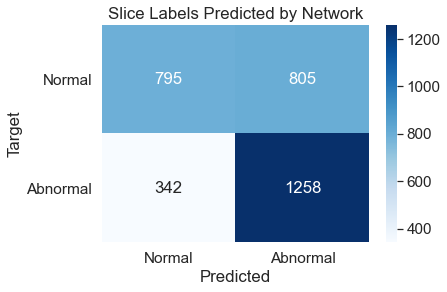

In [12]:
plot_confusion_matrix(targets, predictions, "Slice Labels Predicted by Network")

### Classification Metrics

In [13]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy: {:.2f}".format(accuracy))
print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity))

Accuracy: 0.64
Sensitivity: 0.79
Specificity: 0.50


### ROC Curve & AUC

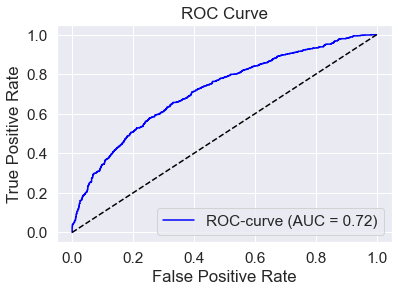

In [14]:
fpr, tpr, thresholds = roc_curve(targets, probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc, "blue")

### Probabilities Per Patient

In [15]:
reset_val_df = val_df.reset_index()

In [16]:
# Separate normal and abnormal patients
normal_patients = np.unique(reset_val_df[~reset_val_df["class"]]["patient_nr"])
print("Normal patients:")
print(normal_patients)
abnormal_patients = np.unique(reset_val_df[reset_val_df["class"]]["patient_nr"])
print("Abnormal patients:")
print(abnormal_patients)

Normal patients:
[  90  122  169  172  235  252  261  277  320  348  366  473  535  536
  549  583  638  640  706  784  807  888  894  973 1002 1163 1170 1185
 1241 1271 1298 1311 1382 1392 1393 1420 1455 1457 1491 1536 1573 1598
 1606 1610 1639 1640 1702 1793 1794 1805]
Abnormal patients:
[  21   37   46   53   88  151  239  243  308  330  341  352  437  456
  521  586  623  655  682  824  864  992 1016 1094 1107 1119 1127 1214
 1228 1229 1272 1276 1402 1612 1623 1625 1646 1658 1745 1893 1906 1930
 1945 1971 1981 2107 2120 2136 2142 2301]


In [17]:
# Extract model outputs (probabilities) for all slices for every normal and abnormal patient
def get_probabilities_for_patients(patients):
    prob_df = pd.DataFrame(columns=range(0,32))
    for patient in patients:
        indices = reset_val_df[reset_val_df["patient_nr"] == patient].index.tolist()
        prob_df.loc[len(prob_df)] = [probabilities[i] for i in indices]
    prob_df.index = patients
    return prob_df

normal_prob_df = get_probabilities_for_patients(normal_patients)
abnormal_prob_df = get_probabilities_for_patients(abnormal_patients)

In [18]:
# Plot the probabilities for all slices corresponding to patients using a seaborn heatmap (row = patient, col = slice index)
def plot_probabilities_for_patients(prob_df, title):
    plt.figure(figsize = (10,(4./15.)*len(prob_df)))
    sn.set(font_scale=1)
    ax = sn.heatmap(prob_df, yticklabels=False, cbar_kws={'label': 'p (abnormal)'})
    ax.hlines(range(len(prob_df)), *ax.get_xlim(), color="white", linewidth=2)
    plt.xlabel("Slice index")
    plt.ylabel("Patient number")
    plt.title(title, fontsize = 15)
    plt.yticks(np.arange(len(prob_df))+0.5,prob_df.index.tolist())

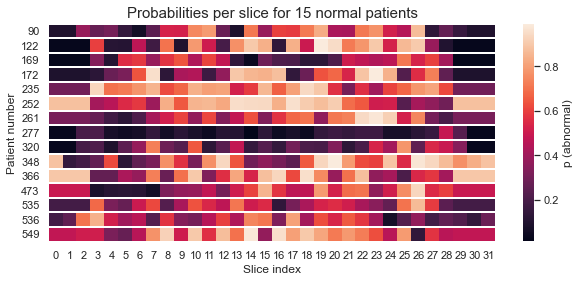

In [19]:
plot_probabilities_for_patients(normal_prob_df.head(15), "Probabilities per slice for 15 normal patients")

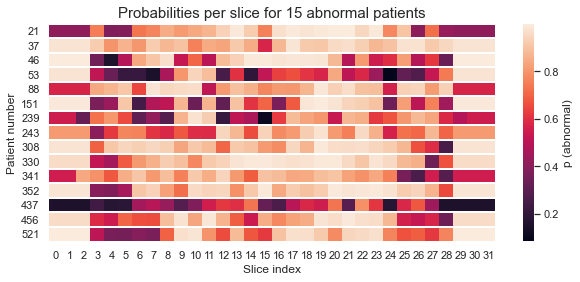

In [20]:
plot_probabilities_for_patients(abnormal_prob_df.head(15), "Probabilities per slice for 15 abnormal patients")

### Plotting Incorrectly Classified (FP, FN) Slices

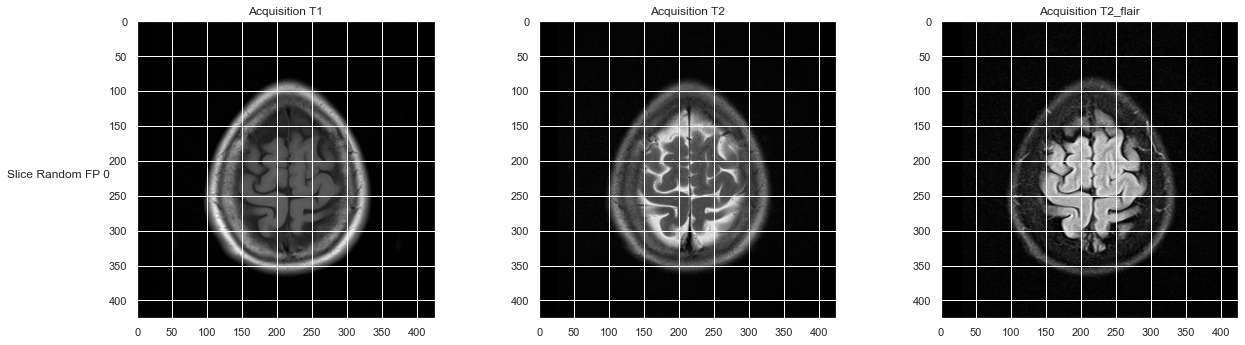

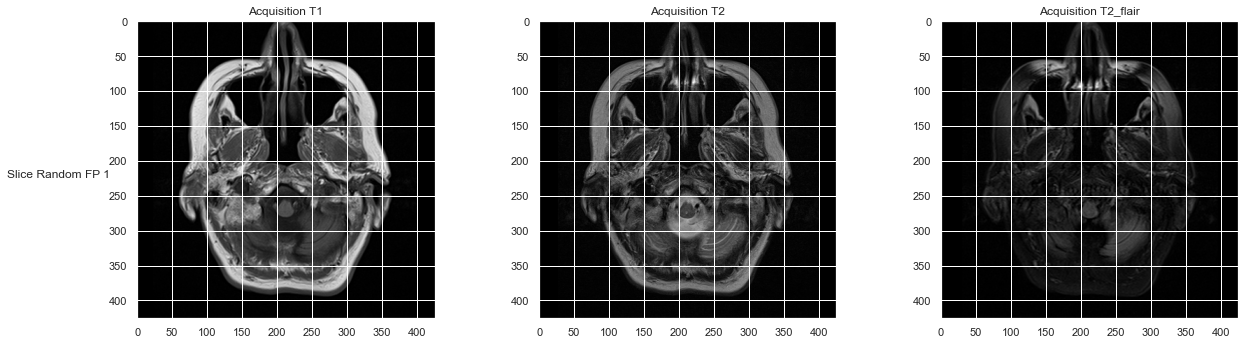

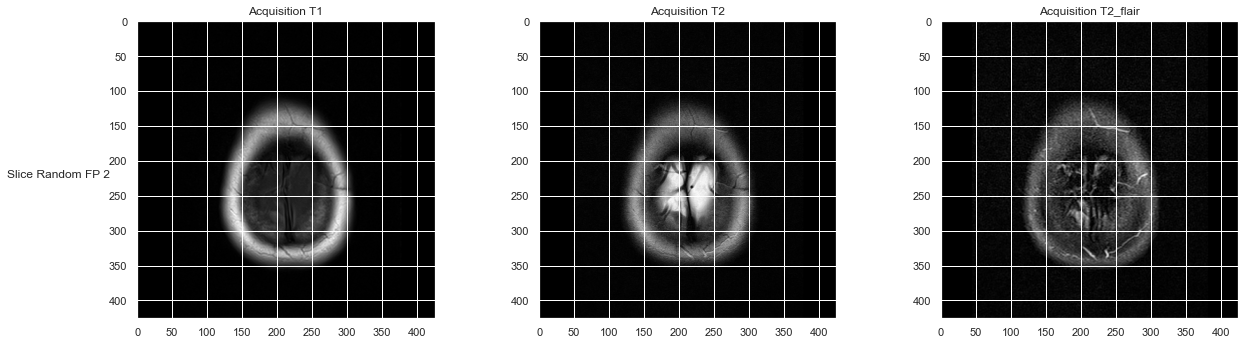

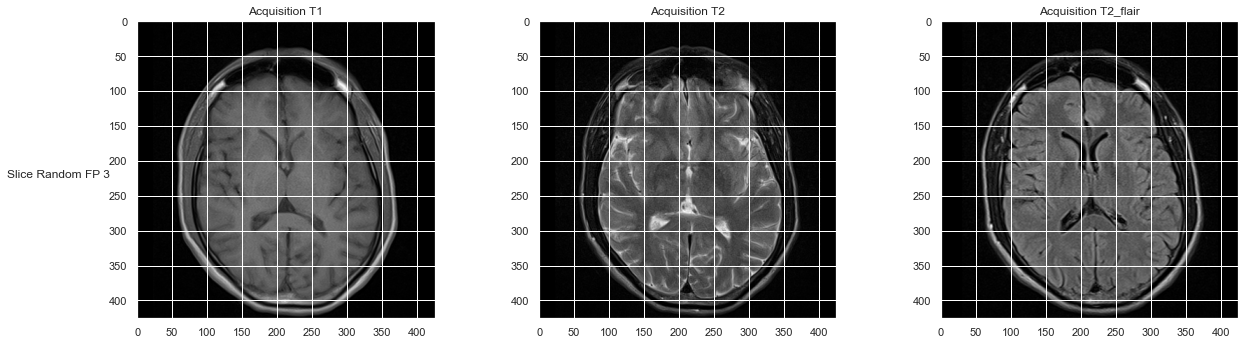

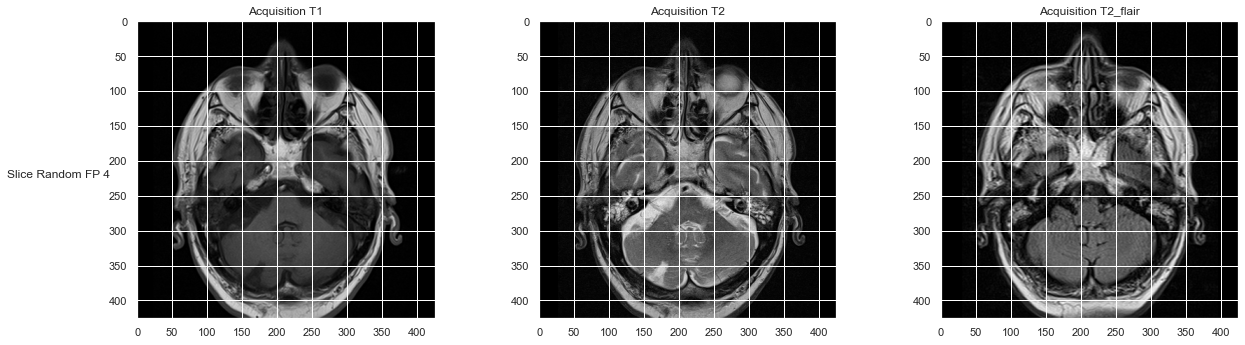

In [21]:
fp_slices = random.sample(fp_img, 5)
for i,fp_slice in enumerate(fp_slices):
    plot_slice_by_acquisition(fp_slice, f"Random FP {i}")

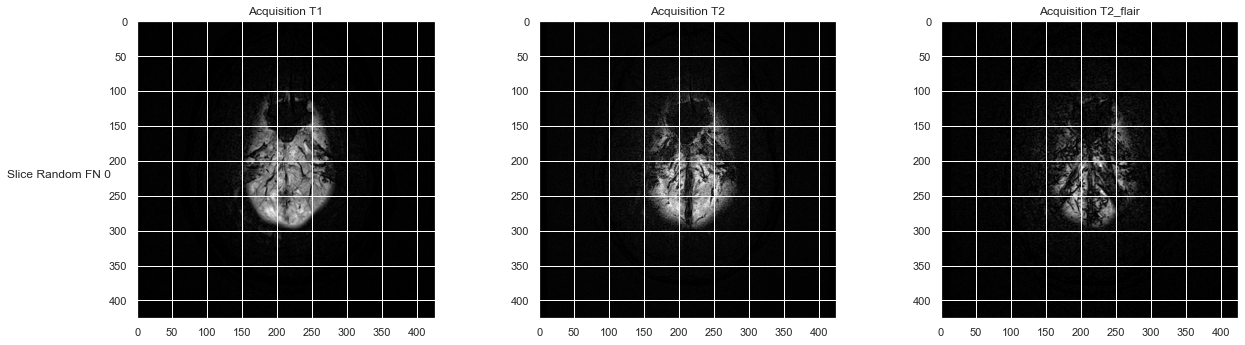

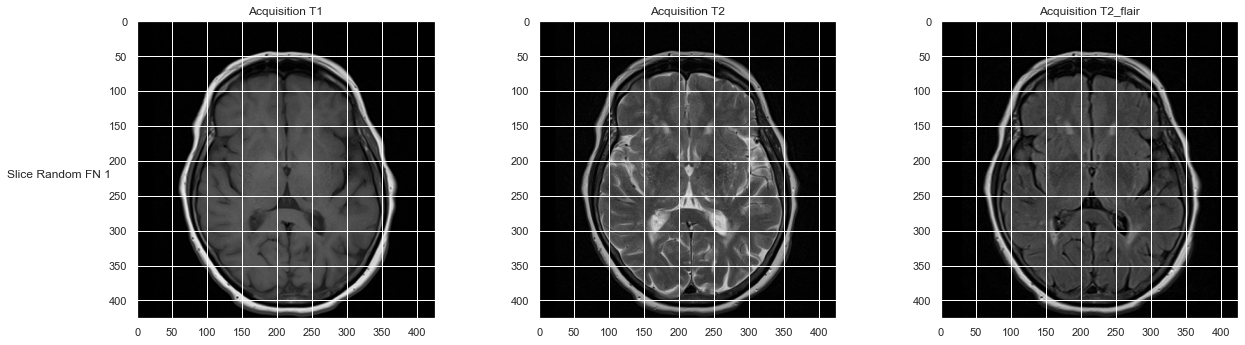

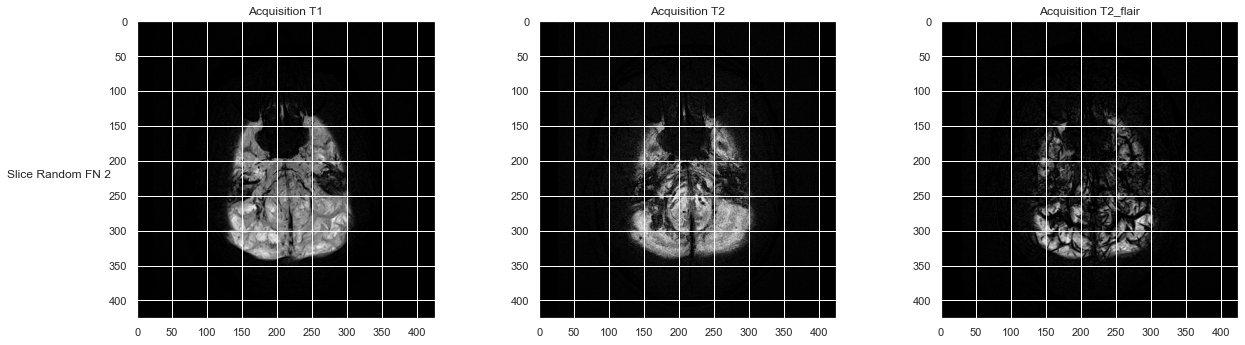

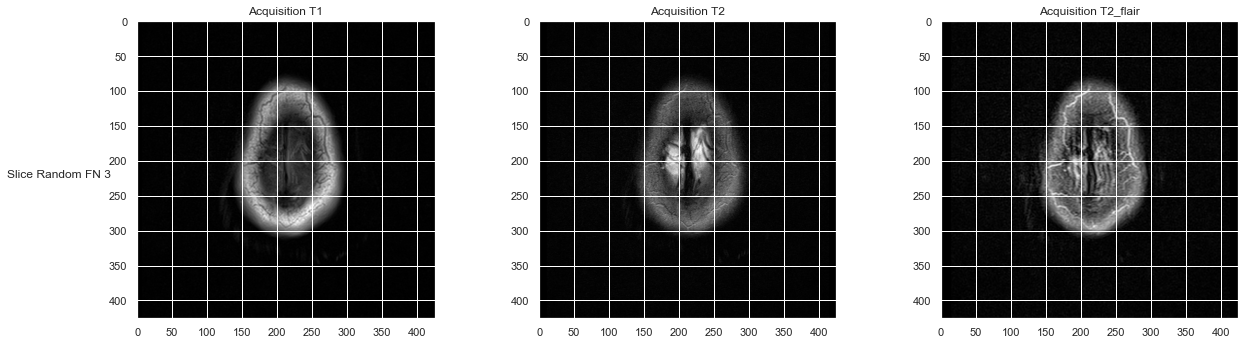

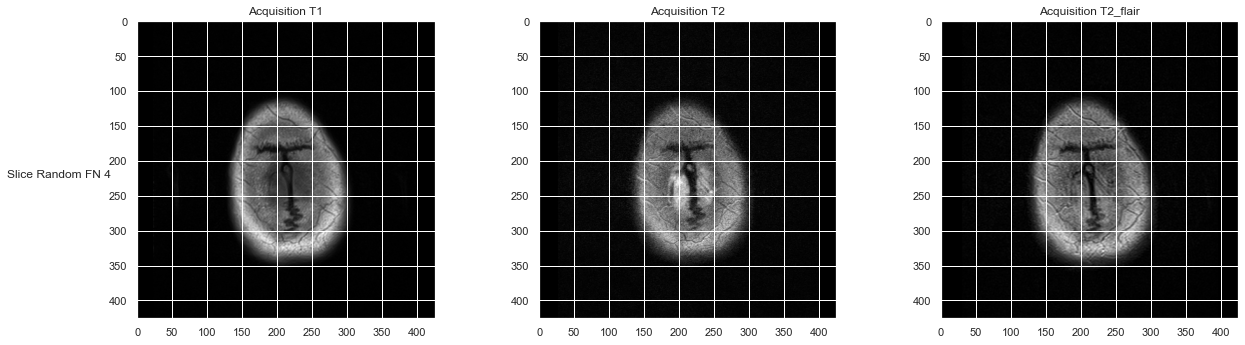

In [22]:
fn_slices = random.sample(fn_img, 5)
for i,fn_slice in enumerate(fn_slices):
    plot_slice_by_acquisition(fn_slice, f"Random FN {i}")